In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
sys.path.insert(0, '..//src/')

c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\notebooks
c:
Users
sceac10
c:\sceac10\


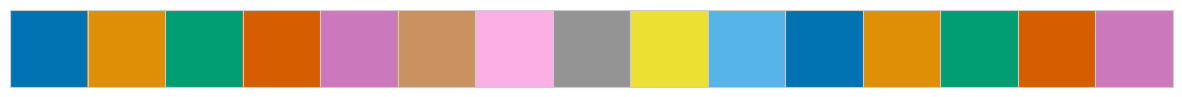

In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import seaborn as sns
import sys
import random
import geopandas as gpd
from common import enums, functions, schema
import main

from pathlib import Path

random.seed(42)

# blues = [x for x in reversed(sns.color_palette("Blues_d", 11))]
# sns.set_palette(sns.color_palette("Paired", 10))
# sns.set_style("white")
sns.set_palette(sns.color_palette("colorblind", 15))
plt.rcParams['font.family'] = 'Times New Roman'
font_size = 12
params = {'axes.labelsize': font_size+2,
          'axes.titlesize':font_size+4,
          'legend.fontsize': font_size, 
          'xtick.labelsize': font_size,
          'ytick.labelsize': font_size,
          'font.size': font_size}
plt.rcParams.update(params)
sns.set_style("whitegrid")
export_fig_format = "pdf"
fig_format = "png"
dpi = 300
figsize = (12, 3.5)
figsize_map = (16, 8)
sns.palplot(sns.color_palette())

markers = ['P', 'o', '^', 's', '*', 'v']
linewidth = 0.1
edgecolor = 'black'

print(os.getcwd())
computer_path= ""
for x in os.getcwd().split(os.path.sep):
    print(x)
    computer_path=computer_path+x+os.path.sep
    if x == "sceac10":
        break    
    else: computer_path = os.getcwd().split(os.path.sep)[0]+os.path.sep
print(computer_path)


In [14]:
PATH_TABLES = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\communication\tables")
PATH_SAVE_FIGURES = Path(r"C:\Users\sceac10\OneDrive - Cardiff University\General\communication\figures")

## Number of households - projection from FES 2023 - Consumer transformation - NZ.22-NZ.25: Estimated number of heating technologies and the associated emissions reduction to 2050

In [15]:
fn = "Dwellings_size.csv"
dataf = pd.read_csv(PATH_TABLES/fn, index_col=0, thousands=r',')
dataf = dataf.dropna(how='any').T
dataf = dataf/1000000
dataf.head()

Year,Number of households
2020,28.762037
2021,28.875423
2022,29.009595
2023,29.133375
2024,29.257157


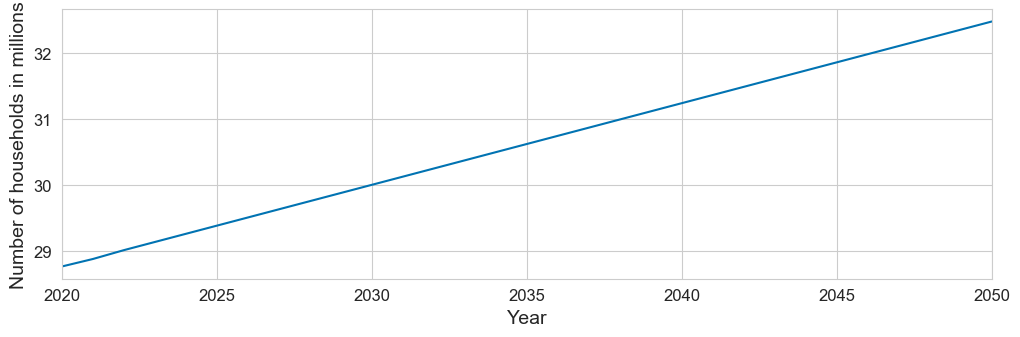

In [16]:
fig, ax = plt.subplots(figsize=figsize)
dataf.plot(ax=ax)
ax.set_ylabel('Number of households in millions')
ax.set_xlabel('Year')
ax.legend().remove()
ax.margins(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"dwelling_projections.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"dwelling_projections.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Normalised profile for equipment gains

In [17]:
PATH_EQUIPMENT_GAINS_PROFILE = Path(r'C:\Users\sceac10\OneDrive - Cardiff University\General\resources\Equipment_gain_profile_TM59.xlsx')
SHEET_EQUIPMENT_GAINS_PROFILE = 'Normalised'

equipment_gains_df = pd.read_excel(PATH_EQUIPMENT_GAINS_PROFILE, sheet_name=SHEET_EQUIPMENT_GAINS_PROFILE, index_col=0)

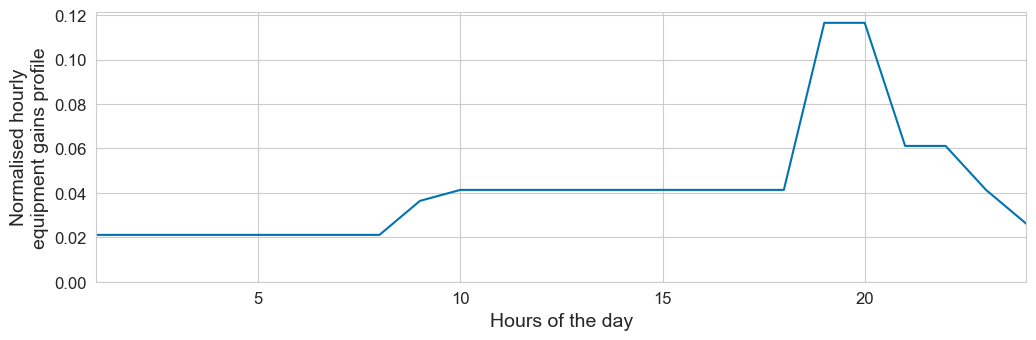

In [18]:



fig, ax = plt.subplots(figsize=figsize)
equipment_gains_df.loc['Normalised profile', :].plot(ax=ax)
ax.set_ylabel('Normalised hourly\nequipment gains profile')
ax.set_xlabel('Hours of the day')
ax.legend().remove()
ax.margins(0, None)
ax.set_ylim(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"equipment_gains.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"equipment_gains.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Temperature profiles from CIBSE

In [19]:
column_names = [
  'Year', 'Month', 'Day', 'Hour', 'PWC', 'Cloud', 'DBT', 'WBT', 'RH', 'Press', 'WD', 'WS', 'GSR', 'DSR', 'Alt', 'Dec', 'Cloud1', 'DBT1', 'WBT1', 'Press1', 'WD1', 'WS1'
]
pathlist = Path(main.PATH_CIBSE_DATA).rglob('*_DSY2_2050High50*.csv')

dict_cibse_temperature: dict[str, pd.Series] = {}
for path in pathlist:
  print(path.stem)
  if ('London' not in path.stem) and ('Belfast' not in path.stem):
    la_str = path.stem.split('_DSY2_2050High50')[0]
    temp_dataf = pd.read_csv(path, skiprows=32, header=None, delimiter=",", names=column_names, parse_dates=True)
    dict_cibse_temperature[la_str] = functions.format_weather_data(temp_dataf)[schema.DataSchema.OAT]

Belfast_DSY2_2050High50_
Birmingham_DSY2_2050High50_
Cardiff_DSY2_2050High50_
Edinburgh_DSY2_2050High50_
Glasgow_DSY2_2050High50_
Leeds_DSY2_2050High50_
London_GTW_DSY2_2050High50
London_LHR_DSY2_2050High50
London_LWC_DSY2_2050High50
Manchester_DSY2_2050High50_


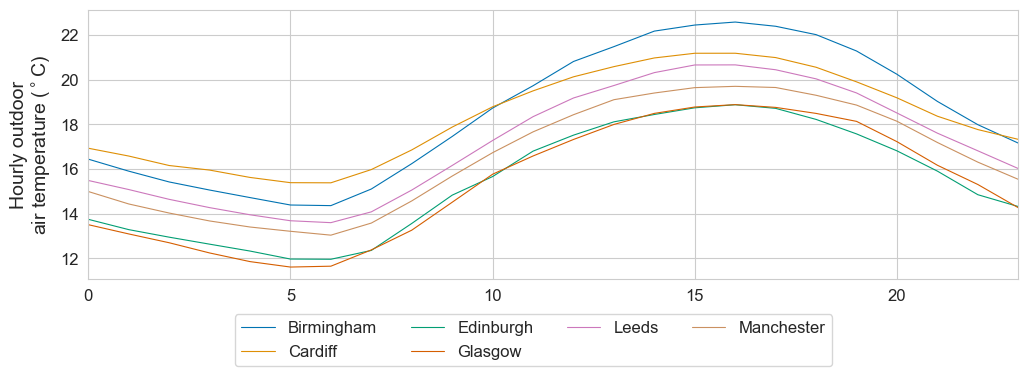

In [20]:
fig, ax = plt.subplots(figsize=figsize)
cibse_temp_df = pd.DataFrame(dict_cibse_temperature)
cibse_temp_df.groupby([cibse_temp_df.index.hour]).mean().plot(ax=ax, linewidth=0.8)
ax.set_ylabel(schema.VisualisationSchema.HOURLY_OAT)
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(0.8, -0.13), ncol=4, borderaxespad=0.)
ax.margins(0, None)

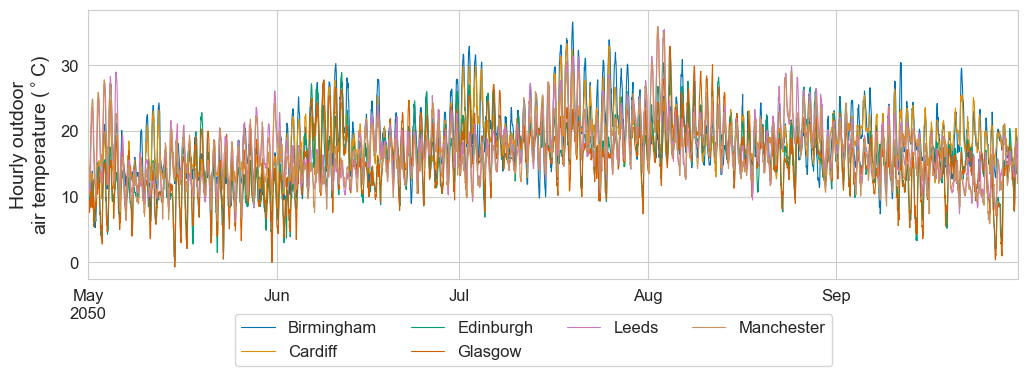

In [21]:
fig, ax = plt.subplots(figsize=figsize)
cibse_temp_df.plot(ax=ax, linewidth=0.8)
ax.set_ylabel(schema.VisualisationSchema.HOURLY_OAT)
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(0.8, -0.13), ncol=4, borderaxespad=0.)
ax.margins(0, None)

fig.savefig(PATH_SAVE_FIGURES/f"cibse_temperature_profiles_DSY2_2050High50.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"cibse_temperature_profiles_DSY2_2050High50.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

## Cooling demand in GB

In [22]:
residential_data = main.import_thermal_characteristics_data(main.PATH_GB_DATA / 'Thermal_characteristics_afterEE.csv', 2020, 2050)
residential_data.head()

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
Index,,,,,,,,,,,,,,,
0,S01006506,aberdeen city,North East Scotland,detached,gas boiler,43906.250000,0.273266,115,17533.867465,175.625000,medium,-5,Edinburgh,S12000033,aberdeen city
1,S01006506,aberdeen city,North East Scotland,detached,oil boiler,66000.000000,0.299051,14,19188.338395,264.000000,medium,-5,Edinburgh,S12000033,aberdeen city
2,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,66187.500000,0.390676,1,25067.327542,264.750000,medium,-5,Edinburgh,S12000033,aberdeen city
3,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,27846.153846,0.216864,68,13914.831788,111.384615,medium,-5,Edinburgh,S12000033,aberdeen city
4,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,22055.555556,0.113292,2,7269.253731,88.222222,medium,-5,Edinburgh,S12000033,aberdeen city


In [23]:
def load_csv_file(temp_path:Path)->pd.DataFrame:
  return pd.read_csv(temp_path, index_col=0)

def get_lsoa_level_results(dataf:pd.DataFrame, index_lsoa_dict:dict[int, str])->pd.DataFrame:
  tuples = [(index_lsoa_dict[int(x)], int(x)) for x in dataf.columns]
  new_columns = pd.MultiIndex.from_tuples(tuples, names=[schema.ResultSchema.LSOA, schema.ResultSchema.INDEX])
  dataf.columns = new_columns
  dataf = dataf.T.groupby(level = 0).sum().T
  return dataf

In [24]:
import icecream as ic

PATH_RESULTS = Path(
    r'C:\Users\sceac10\OneDrive - Cardiff University\General\04 - Analysis\2050 high emission')

pathlist = (Path(PATH_RESULTS)/'simulation').rglob('*_total_heating_outputs.csv')

index_lsoa_dict:dict[int, str] = residential_data[schema.ResultSchema.LSOA].to_dict()

lsoa_peak_frames:dict[str, pd.Series] = {}
index_demand_frames:dict[int, pd.Series] = {}
frames:dict[str, pd.Series] = {}
for temp_path in pathlist:
  ic.ic(temp_path)
  la_str = temp_path.stem.split('_total_heating_outputs')[0]
  la_code = la_str.split('_')[-1]
  temp_sim_results = pd.read_csv(temp_path, index_col=0, parse_dates=True)
  frames[la_code] = -temp_sim_results.sum(axis=1)
  index_demand_frames[la_code] = -temp_sim_results.sum()
  lsoa_level_results = get_lsoa_level_results(-temp_sim_results, index_lsoa_dict)
  lsoa_peak_frames[la_code] = lsoa_level_results.max()


lsoa_peak = pd.concat(lsoa_peak_frames).to_frame()
lsoa_peak.columns = [schema.VisualisationSchema.PEAK_COOLING]
index_demand = pd.concat(index_demand_frames).to_frame()
index_demand.columns = [schema.VisualisationSchema.COOLINGDEMAND]
cooling_demand = pd.DataFrame(frames)
cooling_demand.head()

ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/aberdeen city_S12000033/aberdeen city_S12000033_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/aberdeenshire_S12000034/aberdeenshire_S12000034_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/adur_E07000223/adur_E07000223_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/allerdale_E07000026/allerdale_E07000026_total_heating_outputs.csv')
ic| temp_path: WindowsPath('C:/Users/sceac10/OneDrive - Cardiff University/General/04 - Analysis/2050 high emission/simulation/amber valley_E07000032/amber valley_E07000032_total_heating_outputs.csv')
ic| temp_path

,S12000033,S12000034,E07000223,E07000026,E07000032,S12000041,S12000035,E07000224,E07000170,E07000105,...,E07000217,E08000031,E07000237,E07000229,W06000006,E07000238,E07000007,E07000239,E07000128,E06000014
Time_(h),,,,,,,,,,,,,,,,,,,,,
2050-05-01 00:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2050-05-01 01:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2050-05-01 02:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2050-05-01 03:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0
2050-05-01 04:00:00,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


In [25]:
lsoa_peak.to_csv(PATH_RESULTS/'cooling_peak_results_lsoa.csv')

In [26]:
filt = residential_data[schema.DwellingDataSchema.LSOA]=='E01017461'
residential_data[filt]

,LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm
Index,,,,,,,,,,,,,,,
211856,E01017461,Bedford,East,flat,oil boiler,20699.495206,0.180475,3,8115.289346,82.797981,medium,-3,Birmingham,E06000055,bedford
211857,E01017461,Bedford,East,detached,gas boiler,50028.518519,0.425564,1358,19136.069959,200.114074,medium,-3,Birmingham,E06000055,bedford
211858,E01017461,Bedford,East,detached,resistance heating,23661.875000,0.117001,20,5261.096606,94.647500,medium,-3,Birmingham,E06000055,bedford
211859,E01017461,Bedford,East,detached,oil boiler,52717.187500,0.485382,20,21825.889328,210.868750,medium,-3,Birmingham,E06000055,bedford
211860,E01017461,Bedford,East,semi-detached,gas boiler,23935.398773,0.235840,264,10604.856851,95.741595,medium,-3,Birmingham,E06000055,bedford
211861,E01017461,Bedford,East,semi-detached,resistance heating,18834.187726,0.080986,3,3641.632655,75.336751,medium,-3,Birmingham,E06000055,bedford
211862,E01017461,Bedford,East,semi-detached,oil boiler,23571.250000,0.178684,3,8034.782609,94.285000,medium,-3,Birmingham,E06000055,bedford
211863,E01017461,Bedford,East,semi-detached,biomass boiler,25245.550847,0.207745,3,9341.523929,100.982203,medium,-3,Birmingham,E06000055,bedford
211864,E01017461,Bedford,East,terraced,gas boiler,22391.666667,0.187455,453,8429.166667,89.566667,medium,-3,Birmingham,E06000055,bedford


### Specific cooling demand by dwelling type, dwelling category and heating systems

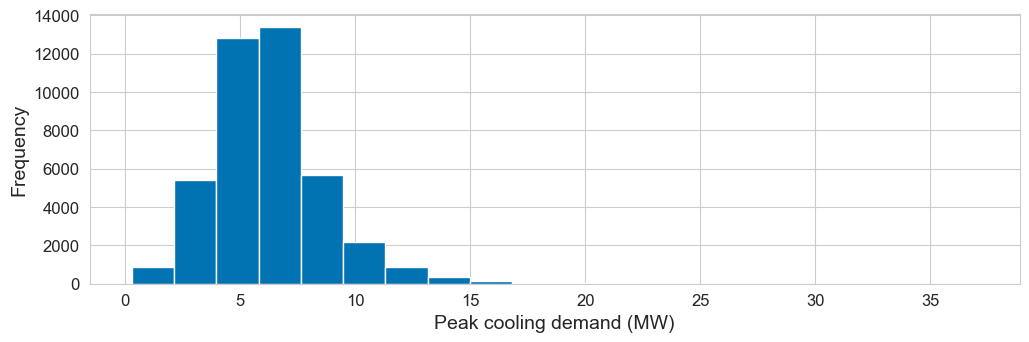

In [27]:
fig, ax = plt.subplots(figsize=figsize)
(lsoa_peak/1000).reset_index(drop=True).plot.hist(bins=20, ax=ax)
ax.set_xlabel('Peak cooling demand (MW)')
ax.legend().remove()

<AxesSubplot: ylabel='Frequency'>

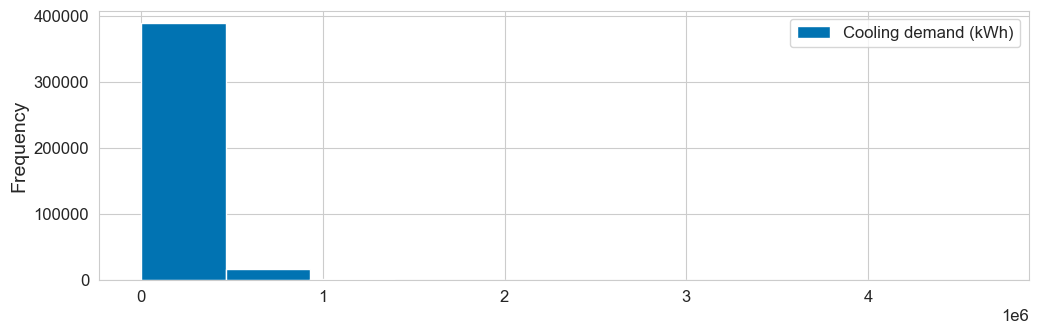

In [28]:
fig, ax = plt.subplots(figsize=figsize)
index_demand.reset_index(drop=True).plot.hist(bins=10, ax=ax)



In [29]:
index_demand.index = index_demand.index.droplevel(0)
index_demand.index= index_demand.index.astype(int)

In [30]:
all_data = pd.merge(index_demand, residential_data, left_index=True, right_index=True)
all_data[schema.ResultSchema.SPECIFICCOOLINGDEMAND_DWELLING] = all_data[schema.ResultSchema.COOLINGDEMAND]/all_data[schema.DwellingDataSchema.NB_DWELLINGS]
all_data[schema.ResultSchema.SPECIFICCOOLINGDEMAND_AREA] = all_data[
    schema.ResultSchema.SPECIFICCOOLINGDEMAND_DWELLING] / all_data[
        schema.DwellingDataSchema.FLOOR_AREA]
all_data.to_csv(PATH_RESULTS/'cooling_demand_results.csv')
all_data.head()


,Cooling demand (kWh),LSOA_code,Local Authority,Region,Dwelling forms,Heating systems,Average thermal capacity kJ/K,Average thermal losses kW/K,Number of dwellings,Average annual heat demand kWh,Average floor area m2,Thermal capacity level,Outdoor air design temperature degreeC,CIBSE_city,ladcd,ladnm,Specific cooling demand (kWh/dwelling),Specific cooling demand (kWh/m2)
0,126454.954648,S01006506,aberdeen city,North East Scotland,detached,gas boiler,43906.250000,0.273266,115,17533.867465,175.625000,medium,-5,Edinburgh,S12000033,aberdeen city,1099.608301,6.261115
1,25046.707408,S01006506,aberdeen city,North East Scotland,detached,oil boiler,66000.000000,0.299051,14,19188.338395,264.000000,medium,-5,Edinburgh,S12000033,aberdeen city,1789.050529,6.776707
2,1626.219750,S01006506,aberdeen city,North East Scotland,detached,biomass boiler,66187.500000,0.390676,1,25067.327542,264.750000,medium,-5,Edinburgh,S12000033,aberdeen city,1626.219750,6.142473
3,45186.995930,S01006506,aberdeen city,North East Scotland,semi-detached,gas boiler,27846.153846,0.216864,68,13914.831788,111.384615,medium,-5,Edinburgh,S12000033,aberdeen city,664.514646,5.965946
4,1287.714036,S01006506,aberdeen city,North East Scotland,semi-detached,resistance heating,22055.555556,0.113292,2,7269.253731,88.222222,medium,-5,Edinburgh,S12000033,aberdeen city,643.857018,7.298127


In [74]:
all_data.head()
temp_pivot_data = pd.pivot_table(all_data, values='Specific cooling demand (kWh/dwelling)', columns='Dwelling forms', index='LSOA_code')
temp_pivot_data.describe()

Dwelling forms,Detached,Flat,Semi-detached,Terraced
count,41559.000000,41611.000000,41660.000000,41691.000000
mean,1784.804515,883.159144,1333.243208,1197.601820
std,712.118163,303.186062,526.218299,446.520788
min,380.484651,206.787224,354.756808,295.918084
25%,1201.527803,611.067052,898.692937,827.861619
50%,1754.027413,904.514386,1408.903934,1243.195183
75%,2280.785695,1134.948717,1696.684007,1528.765755
max,5156.276039,2054.588322,3838.368685,3293.927632


In [75]:
all_data.head()
temp_pivot_data = pd.pivot_table(all_data, values='Average floor area m2', columns='Dwelling forms', index='LSOA_code')
temp_pivot_data.describe()

Dwelling forms,Detached,Flat,Semi-detached,Terraced
count,41559.000000,41611.000000,41660.000000,41691.000000
mean,133.498433,60.126486,94.192509,84.075688
std,33.026911,10.329432,20.234025,16.612534
min,57.000000,28.440000,56.251599,47.500000
25%,110.921280,52.917647,82.363499,74.370056
50%,129.761117,58.919822,90.071266,81.450487
75%,149.469552,65.827240,100.436573,89.927216
max,339.000000,143.000000,227.059342,186.014175


In [76]:
all_data.head()
temp_pivot_data = pd.pivot_table(all_data, values='Specific cooling demand (kWh/m2)', columns='Dwelling forms', index='LSOA_code')
temp_pivot_data.describe()

Dwelling forms,Detached,Flat,Semi-detached,Terraced
count,41559.000000,41611.000000,41660.000000,41691.000000
mean,13.687722,15.016904,14.329189,14.513995
std,4.625404,4.940431,4.805938,4.923006
min,4.639544,5.365957,5.069310,5.032659
25%,9.725223,11.000528,10.493872,10.492042
50%,16.176405,17.866468,16.760917,17.171495
75%,17.999674,19.661763,18.814841,19.201164
max,21.196058,22.330925,21.730723,21.790698


c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


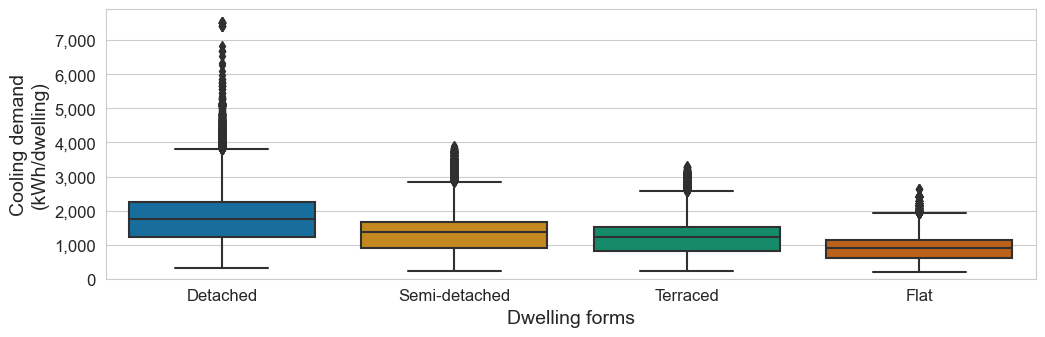

In [70]:
fig, ax = plt.subplots(figsize=figsize)
all_data[schema.DwellingDataSchema.DWELLING_FORMS] = [x.capitalize() for x in all_data[schema.DwellingDataSchema.DWELLING_FORMS]]
sns.boxplot(all_data, x=schema.DwellingDataSchema.DWELLING_FORMS, y=schema.ResultSchema.SPECIFICCOOLINGDEMAND_DWELLING, ax=ax)
ax.set_ylabel(schema.VisualisationSchema.SPECIFICCOOLINGDEMAND_DWELLING)
ax.set_ylim(0, None)
ax.get_yaxis().set_major_formatter(
    tkr.FuncFormatter(lambda x, p: "{:,.0f}".format(x)))

c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(0.0, 23.605426869416913)

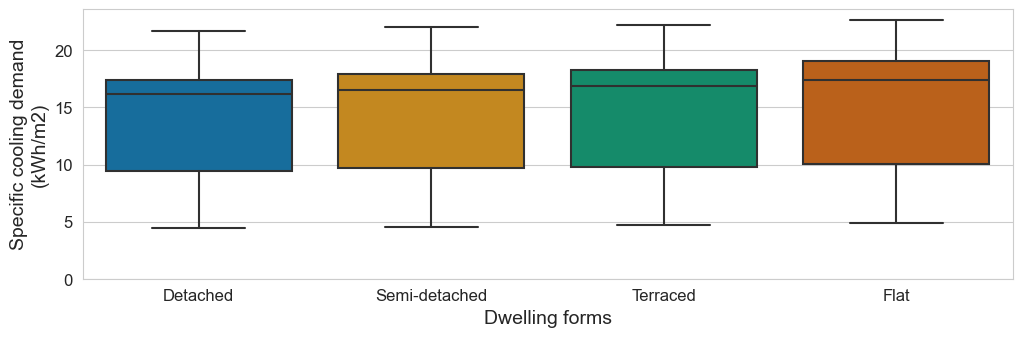

In [71]:
fig, ax = plt.subplots(figsize=figsize)
sns.boxplot(all_data, x=schema.DwellingDataSchema.DWELLING_FORMS, y=schema.ResultSchema.SPECIFICCOOLINGDEMAND_AREA, ax=ax)
ax.set_ylabel(schema.VisualisationSchema.SPECIFICCOOLINGDEMAND_AREA)
ax.set_ylim(0, None)

In [65]:
(cooling_demand.sum(axis=1)/1000000).sum()

38234.490018100856

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


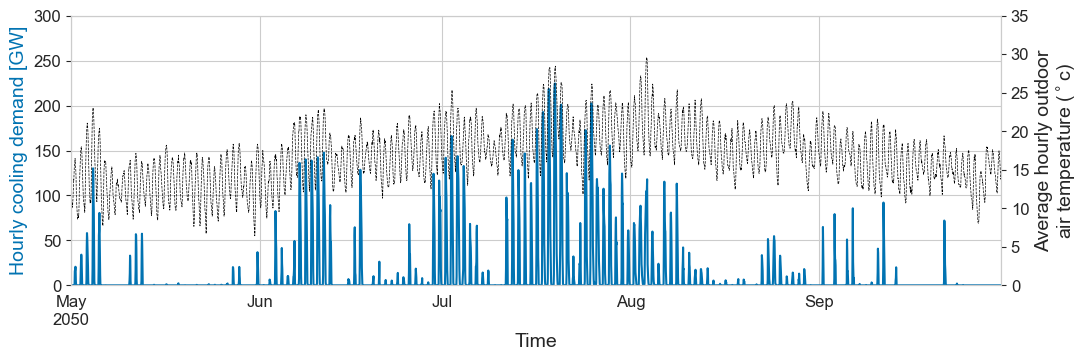

In [63]:
fig, ax = plt.subplots(figsize=figsize)

ax2 = ax.twinx()
(cooling_demand.sum(axis=1)/1000000).plot(ax=ax)
ax.set_ylabel('Hourly cooling demand [GW]', color=sns.color_palette()[0])
ax.set_xlabel('Time')
ax.set_ylim(0, 300)
ax.legend().remove()
ax.margins(0, None)

pd.DataFrame(dict_cibse_temperature).mean(axis=1).plot(ax=ax2, linewidth=0.5, color='black', linestyle='--')
ax2.set_ylabel(f'Average {schema.VisualisationSchema.HOURLY_OAT.lower()}')
ax2.set_ylim(0, 35)
ax2.grid(False)
# ax.set_ylim(0, None)
fig.savefig(PATH_SAVE_FIGURES/f"cooling_demand_GB.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"cooling_demand_GB.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

In [ ]:
### Electricity for cooling

In [83]:
scop=14/3.412 #https://www.eia.gov/todayinenergy/detail.php?id=40232
cop = scop*0.875

In [88]:
ic.ic('electricity for cooling', (cooling_demand.sum(axis=1)/1000000/scop).sum())
ic.ic('max cooling demand',(cooling_demand.sum(axis=1)/1000000/cop).max())
ic.ic('95% percentiles cooling demand',(cooling_demand.sum(axis=1)/1000000/cop).quantile(0.95))

ic| 'electricity for cooling': 'electricity for cooling'
    (cooling_demand.sum(axis=1)/1000000/scop).sum(): 9318.29142441144
ic| 'max cooling demand': 'max cooling demand'
    (cooling_demand.sum(axis=1)/1000000/cop).max(): 62.59201223409298
ic| '95% percentiles cooling demand': '95% percentiles cooling demand'
    (cooling_demand.sum(axis=1)/1000000/cop).quantile(0.95): 23.12285750018515


('95% percentiles cooling demand', 23.12285750018515)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


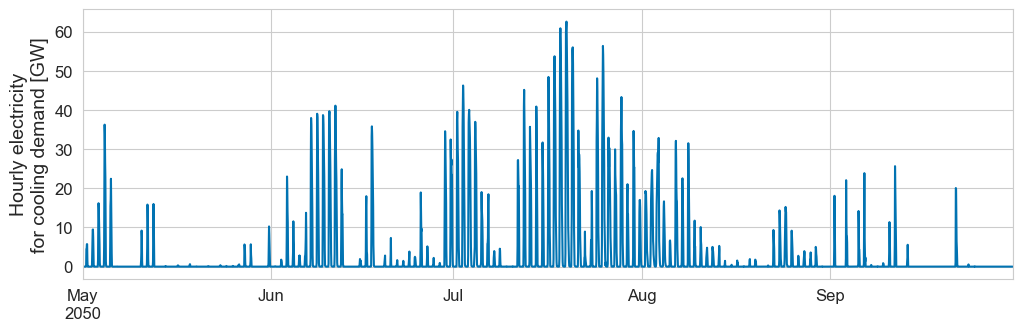

In [87]:
fig, ax = plt.subplots(figsize=figsize)

(cooling_demand.sum(axis=1)/1000000/cop).plot(ax=ax)
ax.set_ylabel('Hourly electricity\nfor cooling demand [GW]')
ax.set_xlabel('')
# ax.set_ylim(0, 300)
ax.legend().remove()
ax.margins(0, None)


# ax.set_ylim(0, None)
fig.savefig(PATH_SAVE_FIGURES/f"electricity_for_cooling_demand_GB.{fig_format}", bbox_inches='tight', format=fig_format, dpi=dpi)
fig.savefig(PATH_SAVE_FIGURES/f"electricity_for_cooling_demand_GB.{export_fig_format}", bbox_inches='tight', format=export_fig_format, dpi=dpi)

In [46]:
path_map =  Path(r"D:\OneDrive - Cardiff University\04 - Projects\03 - PhD\03 - Analysis\03 - LSOAs\00 - Data\GIS map and data")
file = "Local_authority_UK_2019.geojson"
path_map = path_map/file

In [57]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def create_map_LA(df,
                  target,
                  path_map,
                  fig,
                  ax,
                  cmap=None,
                  percentage_scale=False, label_legend:str=''):

  map_df = gpd.read_file(path_map)
  map_df.crs = {'init': 'epsg:4326'}

  map_df = pd.merge(map_df,
                    df,
                    left_on="lad19cd",
                    right_on=schema.DwellingDataSchema.LADCD,
                    how="left")

  map_df = map_df.dropna(subset=[target])
  # create figure and axes for Matplotlib
  if percentage_scale:
    vmin = 0
    vmax = 1
  else:
    vmin = 0
    vmax = map_df[target].max()

  if cmap == None:
    cmap = 'Blues'

  ax.axis('off')
  ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

  map_df = map_df.to_crs({'init': 'epsg:3395'})  # mercator projections
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.1)

  map = map_df.plot(column=target,
              cmap=cmap,
              linewidth=0.015,
              ax=ax,
              edgecolor='black',
              vmin=vmin,
              vmax=vmax,
              legend=True,
              legend_kwds={
                      "label": label_legend,
                      "orientation": "vertical"
                      },
              cax=cax)  #,
  plt.close()
  return map



In [119]:
# Peak cooling demand in MW
la_cooling_demand = cooling_demand.max()
la_cooling_demand = la_cooling_demand.to_frame()
la_cooling_demand = la_cooling_demand.reset_index()
la_cooling_demand.columns = [
    schema.DwellingDataSchema.LADCD, schema.DwellingDataSchema.COOLING_DEMAND]
la_cooling_demand.head()

,ladcd,Cooling demand (kWh)
0,S12000033,9.391602e+05
1,S12000034,1.308641e+06
2,E07000223,2.508046e+05
3,E07000026,4.593334e+05
4,E07000032,5.446451e+05


In [124]:
la_cooling_demand.sort_values(schema.DwellingDataSchema.COOLING_DEMAND, ascending=False).describe()/1000

,Cooling demand (kWh)
count,0.371000
mean,700.625637
std,428.247217
min,6.014953
25%,435.946683
50%,593.059954
75%,823.362680
max,3640.676891


c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


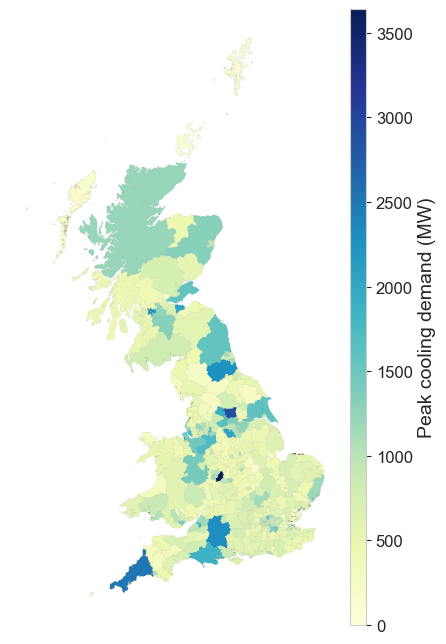

In [60]:


to_plot_df = la_cooling_demand.copy()

fig, ax = plt.subplots(figsize=(figsize_map))
target = schema.DwellingDataSchema.COOLING_DEMAND
to_plot_df[target] = to_plot_df[target]/1000

cmap_1 = "YlGnBu"
create_map_LA(to_plot_df, target, path_map, fig, ax, cmap=cmap_1, label_legend='Peak cooling demand (MW)')

fig

In [116]:
all_data['Total Floor area'] = all_data[schema.DwellingDataSchema.NB_DWELLINGS]*all_data[schema.DwellingDataSchema.FLOOR_AREA]
la_data = all_data.groupby(schema.DwellingDataSchema.LADNM).agg({schema.DwellingDataSchema.COOLING_DEMAND:'sum',
                                                       schema.DwellingDataSchema.NB_DWELLINGS:'sum',
                                                       schema.DwellingDataSchema.FLOOR_AREA:'mean',
                                                       schema.DwellingDataSchema.HEATING_DEMAND:'sum',
                                                       'Total Floor area':'sum'})


la_data.head()

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
count,0.000371,0.000371,0.000371,0.000371,0.000371
mean,103.057925,0.079144,0.000094,9.628140,7.378902
std,68.288461,0.052287,0.000008,6.988232,4.606471
min,1.380067,0.000804,0.000076,0.128460,0.070662
25%,56.939838,0.046426,0.000089,5.757047,4.524467
50%,89.728612,0.062779,0.000094,7.825474,6.173945
75%,130.399441,0.097391,0.000099,10.420027,8.737968
max,679.717599,0.429934,0.000136,45.090612,37.883737


In [117]:
la_data.sort_values(schema.DwellingDataSchema.HEATING_DEMAND, ascending=False).head(10)

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
ladnm,,,,,
fife,1.335424e+08,199550,98.336276,4.509061e+07,1.876664e+07
highland,1.114047e+08,133170,101.942208,4.473406e+07,1.480305e+07
aberdeenshire,1.017068e+08,133173,107.960311,4.374446e+07,1.598449e+07
city of edinburgh,1.844885e+08,281653,102.078396,4.226483e+07,2.475338e+07
glasgow city,1.891122e+08,351191,93.304625,4.120045e+07,2.743365e+07
birmingham,6.797176e+08,429934,86.689080,4.091272e+07,3.788374e+07
south lanarkshire,1.018329e+08,170595,97.937723,3.750335e+07,1.605280e+07
cornwall,4.672335e+08,263122,93.917608,3.728852e+07,2.606400e+07
county durham,2.301110e+08,256969,98.895163,3.514359e+07,2.342018e+07


In [113]:
la_data.sort_values('Total Floor area', ascending=False).head(10)

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Total Floor area
ladnm,,,,
birmingham,6.797176e+08,429934,86.689080,3.788374e+07
leeds,3.083777e+08,353997,88.126937,3.076655e+07
glasgow city,1.891122e+08,351191,93.304625,2.743365e+07
cornwall,4.672335e+08,263122,93.917608,2.606400e+07
city of edinburgh,1.844885e+08,281653,102.078396,2.475338e+07
county durham,2.301110e+08,256969,98.895163,2.342018e+07
wiltshire,4.088655e+08,229628,94.884308,2.331301e+07
sheffield,2.110715e+08,247619,85.699676,2.130431e+07
bradford,1.961831e+08,214049,93.994153,2.012659e+07


In [118]:
la_data.sort_values(schema.DwellingDataSchema.COOLING_DEMAND, ascending=False).head(10)

,Cooling demand (kWh),Number of dwellings,Average floor area m2,Average annual heat demand kWh,Total Floor area
ladnm,,,,,
birmingham,6.797176e+08,429934,86.689080,4.091272e+07,3.788374e+07
cornwall,4.672335e+08,263122,93.917608,3.728852e+07,2.606400e+07
wiltshire,4.088655e+08,229628,94.884308,3.159743e+07,2.331301e+07
dorset,3.309825e+08,185289,96.044726,2.197097e+07,1.889193e+07
"bristol, city of",3.273095e+08,207927,92.260612,1.867514e+07,1.848200e+07
"bournemouth, christchurch and poole",3.121481e+08,193020,88.893288,1.498053e+07,1.767883e+07
leeds,3.083777e+08,353997,88.126937,3.476330e+07,3.076655e+07
barnet,2.680281e+08,156251,97.739228,1.458594e+07,1.527083e+07
shropshire,2.615733e+08,142242,97.650552,2.440653e+07,1.473637e+07


c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\sceac10\OneDrive - Cardiff University\General\code\degree-days-analysis\degree_days\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


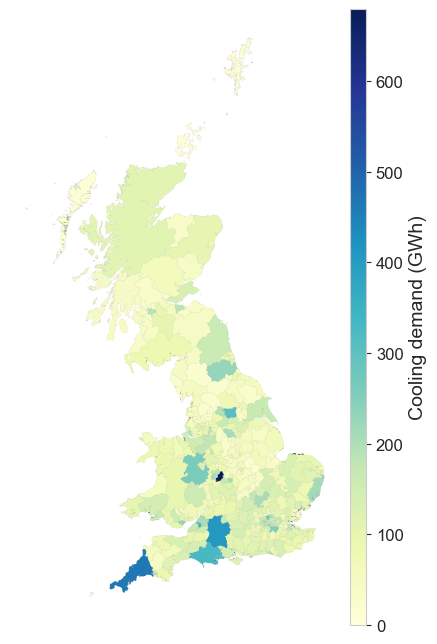

In [92]:
# Annual cooling demand GWh
la_cooling_demand = cooling_demand.sum()
la_cooling_demand = la_cooling_demand.to_frame()
la_cooling_demand = la_cooling_demand.reset_index()
la_cooling_demand.columns = [
    schema.DwellingDataSchema.LADCD, schema.DwellingDataSchema.COOLING_DEMAND]
la_cooling_demand.head()


to_plot_df = la_cooling_demand.copy()

fig, ax = plt.subplots(figsize=(figsize_map))
target = schema.DwellingDataSchema.COOLING_DEMAND
to_plot_df[target] = to_plot_df[target]/1000000

cmap_1 = "YlGnBu"
create_map_LA(to_plot_df, target, path_map, fig, ax, cmap=cmap_1, label_legend='Cooling demand (GWh)')

fig

## Substation analysis of NationalGrid South Wales (not used)

In [32]:
substation_df = pd.read_csv(PATH_RESULTS / 'substation_analysis.csv')
substation_df.head()

,Substation,Thermal demand headroom (kW),Peak cooling demand (kW),Thermal demand headroom after cooling demand (kW)
0,Aberaeron,-12770.0,16048.888805,-28818.888805
1,Abercrave,200.0,15862.653188,-15662.653188
2,Aberdare,-34226.0,102225.758869,-136451.758869
3,Abergavenny Primary,-34180.0,112010.309102,-146190.309102
4,Aberpergwm,5840.0,27246.916832,-21406.916832


In [127]:
def plot_map(map_df,
             target,
             ax,
             vmin=None,
             vmax=None,
             cmap=None,
             legend=False):

  map_df = map_df.dropna(subset=[target])
  # create figure and axes for Matplotlib
  if vmin is None:
    if map_df[target].min() < 0:
      vmin = map_df[target].min()
    else:
      vmin = 0
  if vmax is None:
    vmax = map_df[target].max()

  if cmap == None:
    cmap = 'Blues'

  ax.axis('off')
  ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

  map_df = map_df.to_crs(epsg=3395)  # mercator projections

  if legend:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    map = map_df.plot(column=target,
                      cmap=cmap,
                      linewidth=0.01,
                      ax=ax,
                      edgecolor='black',
                      vmin=vmin,
                      vmax=vmax,
                      legend=legend,
                      legend_kwds={
                          "label": "Demand headroom (MW)",
                          "orientation": "horizontal"
                      },
                      cax=cax)
  else:
    map = map_df.plot(column=target,
                      cmap=cmap,
                      linewidth=0.01,
                      ax=ax,
                      edgecolor='black',
                      vmin=vmin,
                      vmax=vmax)
  plt.close()
  return map


In [87]:
PATH_SUBSTATION_MAP = Path(
    r'C:\Users\sceac10\OneDrive - Cardiff University\General\data\Electricity substation data\national grid'
)
fn = 'south_wales_primary.geojson'
path_map = PATH_SUBSTATION_MAP/fn
map_df = gpd.read_file(path_map)
map_df.head()

,fid,PRIM_NRID_NAME,PRIM_NRID,PRIM_NR,BSP_NRID_NAME,BSP_NRID,BSP_NR,GSP_NRID_NAME,GSP_NRID,GSP_NR,geometry
0,4,Crumlin Primary,253423,550011,Crumlin,245447,550011,Rassau G.S.P.,245530,550906,"MULTIPOLYGON (((318919.325 195964.101, 318890...."
1,1455,PRESTEIGNE 66 11kV S STN,314954,670111,HEREFORD 66kV S STN,314601,670013,BISHOPS WOOD 132kV S STN,314538,670002,"MULTIPOLYGON (((328574.961 265150.011, 328578...."
2,1462,KNIGHTON 66 11kV S STN,315046,670121,HEREFORD 66kV S STN,314601,670013,BISHOPS WOOD 132kV S STN,314538,670002,"MULTIPOLYGON (((309902.662 282939.840, 309908...."
3,3237,Barry Grid Primary,252467,510088,Barry Grid,245423,510088,Aberthaw Power Station,245414,510049,"MULTIPOLYGON (((308850.110 166738.797, 308846...."
4,3239,Ship Hill Barry,245514,510223,Barry Grid,245423,510088,Aberthaw Power Station,245414,510049,"MULTIPOLYGON (((312530.691 166548.735, 312523...."


In [88]:
to_plot_df = substation_df[[
    'Substation', schema.VisualisationSchema.DEMAND_HEADROOM,
    schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING
]].copy()
to_plot_df[[schema.VisualisationSchema.DEMAND_HEADROOM,
    schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING]] = to_plot_df[[schema.VisualisationSchema.DEMAND_HEADROOM,
    schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING]]/1000
map_df = pd.merge(map_df,
                  to_plot_df,
                  left_on="PRIM_NRID_NAME",
                  right_on='Substation',
                  how="left")
map_df.head()

,fid,PRIM_NRID_NAME,PRIM_NRID,PRIM_NR,BSP_NRID_NAME,BSP_NRID,BSP_NR,GSP_NRID_NAME,GSP_NRID,GSP_NR,geometry,Substation,Thermal demand headroom (kW),Thermal demand headroom after cooling demand (kW)
0,4,Crumlin Primary,253423,550011,Crumlin,245447,550011,Rassau G.S.P.,245530,550906,"MULTIPOLYGON (((318919.325 195964.101, 318890....",Crumlin Primary,-21.03,-99.454962
1,1455,PRESTEIGNE 66 11kV S STN,314954,670111,HEREFORD 66kV S STN,314601,670013,BISHOPS WOOD 132kV S STN,314538,670002,"MULTIPOLYGON (((328574.961 265150.011, 328578....",NaN,NaN,NaN
2,1462,KNIGHTON 66 11kV S STN,315046,670121,HEREFORD 66kV S STN,314601,670013,BISHOPS WOOD 132kV S STN,314538,670002,"MULTIPOLYGON (((309902.662 282939.840, 309908....",NaN,NaN,NaN
3,3237,Barry Grid Primary,252467,510088,Barry Grid,245423,510088,Aberthaw Power Station,245414,510049,"MULTIPOLYGON (((308850.110 166738.797, 308846....",Barry Grid Primary,-33.08,-144.562281
4,3239,Ship Hill Barry,245514,510223,Barry Grid,245423,510088,Aberthaw Power Station,245414,510049,"MULTIPOLYGON (((312530.691 166548.735, 312523....",Ship Hill Barry,11.26,-16.764718


In [92]:
vmin = to_plot_df[[
    schema.VisualisationSchema.DEMAND_HEADROOM,
    schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING
]].min().min()
vmax = to_plot_df[[
    schema.VisualisationSchema.DEMAND_HEADROOM,
    schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING
]].max().max()

-411.4533612589684

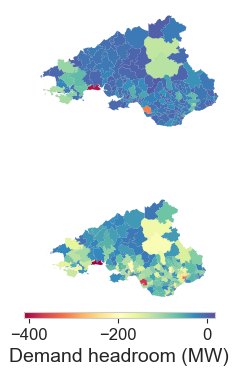

In [129]:
fig, axs = plt.subplots(2, 1, figsize=(figsize[1],round(figsize[1])) )
plt.subplots_adjust(wspace=0, hspace=0.5)
cmap_1 = 'Spectral'

ax = axs[0]
target = schema.VisualisationSchema.DEMAND_HEADROOM
plot_map(map_df, target, ax, vmin, vmax, cmap=cmap_1, legend=False)

ax = axs[1]
target = schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING
plot_map(map_df, target, ax,vmin, vmax, cmap=cmap_1, legend=True)
fig

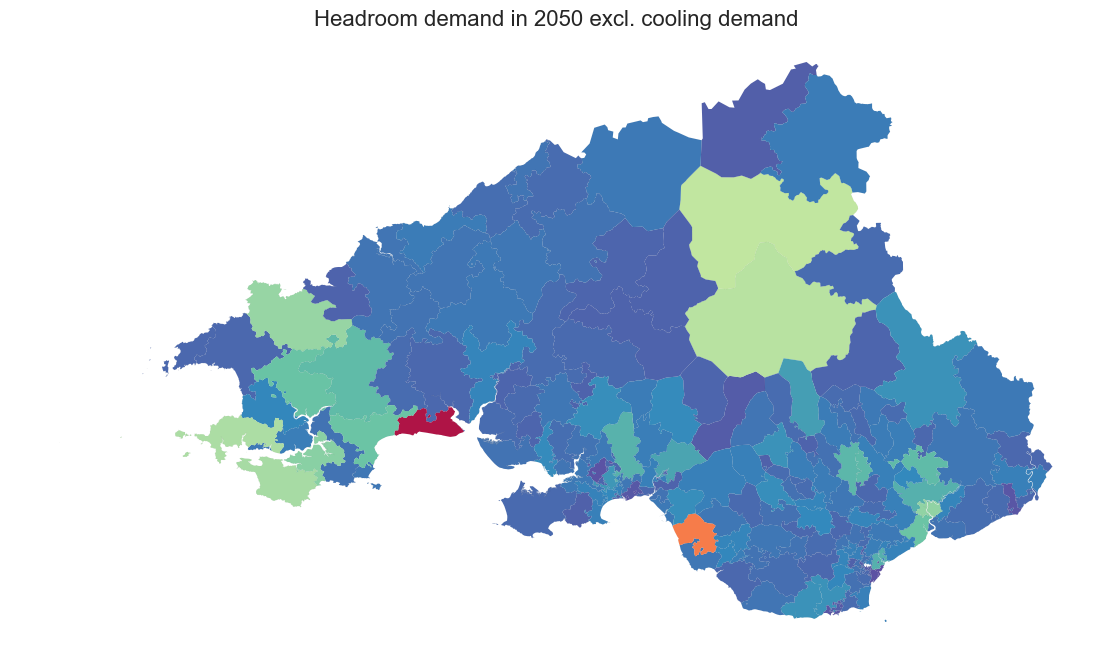

In [132]:
fig, ax = plt.subplots(figsize=(figsize_map))
cmap_1 = 'Spectral'
target = schema.VisualisationSchema.DEMAND_HEADROOM
plot_map(map_df, target, ax, vmin, vmax, cmap=cmap_1, legend=False)
ax.set_title('Headroom demand in 2050 excl. cooling demand')
fig

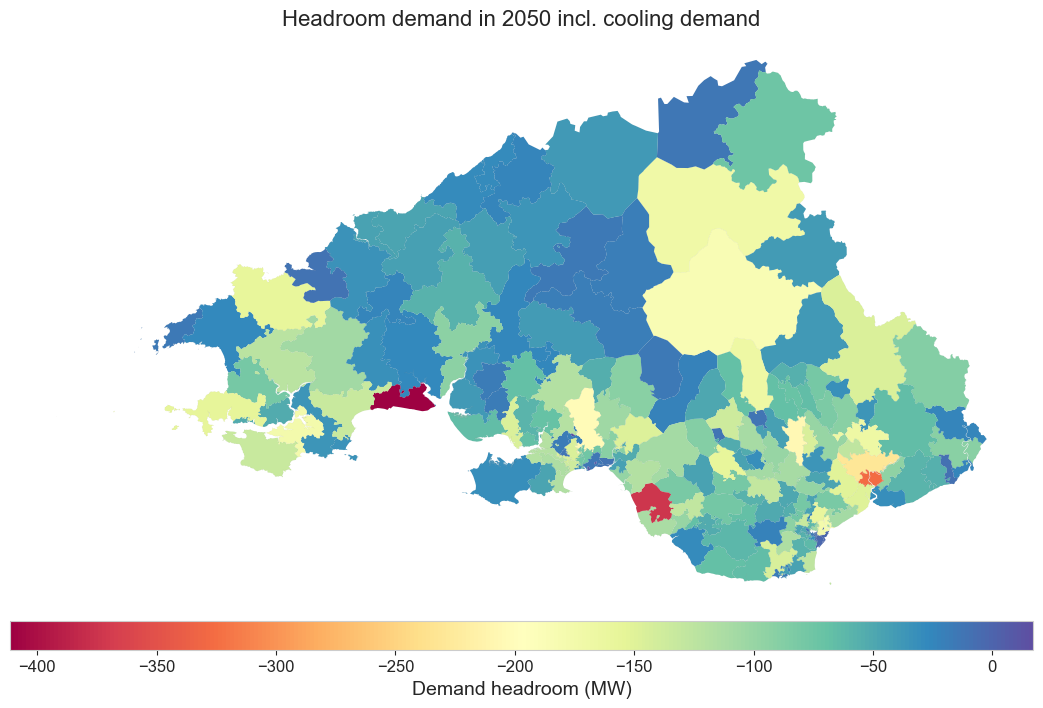

In [133]:
fig, ax = plt.subplots(figsize=(figsize_map))
target = schema.VisualisationSchema.DEMAND_HEADROOM_AFTER_COOLING
plot_map(map_df, target, ax, vmin, vmax, cmap=cmap_1, legend=True)
ax.set_title('Headroom demand in 2050 incl. cooling demand')
fig